In [55]:
# import networkx
import lovelyplots
import networkx as nx
import numpy as np
import rustworkx as rx
import scienceplots
from rustworkx.visualization import graphviz_draw, mpl_draw
from scipy.optimize import minimize

from corral_crowding.allocation_optimizer import GateFidelityOptimizer
from corral_crowding.detuning_fit import compute_infidelity_parameters, decay_fit
from corral_crowding.module_graph import QuantumModuleGraph

# import networkx
import lovelyplots
import networkx as nx
import numpy as np
import rustworkx as rx
import scienceplots
from rustworkx.visualization import graphviz_draw, mpl_draw
from scipy.optimize import minimize
from scipy.stats import gmean
from tqdm import tqdm

from corral_crowding.detuning_fit import compute_infidelity_parameters, decay_fit
from corral_crowding.module_graph import QuantumModuleGraph
from corral_crowding.speedlimit_fit import (
    lifetime_decay_fit,
    speedlimit_infidelity_params,
)
import numpy as np
from scipy.optimize import minimize
from tqdm import tqdm

In [ ]:
module = QuantumModuleGraph(num_qubits=4)
optimizer1 = GateFidelityOptimizer(
    module,
    min_bare_space_ghz=0.2,
    lambdaq=0.08,
    eta=1.8,
    g3=60e6,
    qubit_bounds=(3.3, 5.7),
    snail_bounds=(4.2, 4.7),
    use_lifetime=True,
)
optimizer2 = GateFidelityOptimizer(
    module,
    min_bare_space_ghz=0.2,
    lambdaq=0.08,
    eta=1.8,
    g3=60e6,
    qubit_bounds=(3.3, 5.7),
    snail_bounds=(4.7, 4.7),
    use_lifetime=True,
)
# opt_frequencies, opt_cost = optimizer.optimize_frequencies()
# optimizer.report_results()
freqs = [5.35227061, 5.15215558, 5.67239046, 3.30930272, 4.30944922220373]
# freqs = [4.0014652, 3.48124514, 3.80146415, 4.70359171, 4.25349306]
1 - optimizer1.compute_total_infidelity(freqs)
1 - np.array(optimizer1.get_final_infidelities(freqs))

array([0.98486022, 0.98705223, 0.98824728, 0.9907698 , 0.99254166,
       0.99676473])

100%|██████████| 512/512 [05:27<00:00,  1.56it/s]

Best joint cost: 0.1276882342819733
Frequencies: [3.3        5.68650645 5.48649582 5.16047071 4.40010037 4.20004206]

=== Module 1 ===
Qubit Frequencies: [3.300000000000315, 5.686506453094129, 5.486495816489926, 5.1604707113269015] GHz
SNAIL Frequency: 4.400100368976565 GHz
Gate Infidelities:
  Gate ('Q0', 'Q1'): 2.386506 GHz → fidelity (no lifetime loss): 9.918764e-01, fidelity (with lifetime loss): 9.877958e-01
  Gate ('Q0', 'Q2'): 2.186496 GHz → fidelity (no lifetime loss): 9.969165e-01, fidelity (with lifetime loss): 9.917305e-01
  Gate ('Q0', 'Q3'): 1.860471 GHz → fidelity (no lifetime loss): 9.901307e-01, fidelity (with lifetime loss): 9.866939e-01
  Gate ('Q1', 'Q2'): 0.200011 GHz → fidelity (no lifetime loss): 9.974676e-01, fidelity (with lifetime loss): 9.961828e-01
  Gate ('Q1', 'Q3'): 0.526036 GHz → fidelity (no lifetime loss): 9.798575e-01, fidelity (with lifetime loss): 9.784176e-01
  Gate ('Q2', 'Q3'): 0.326025 GHz → fidelity (no lifetime loss): 9.931592e-01, fidelity (wi

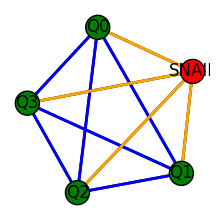

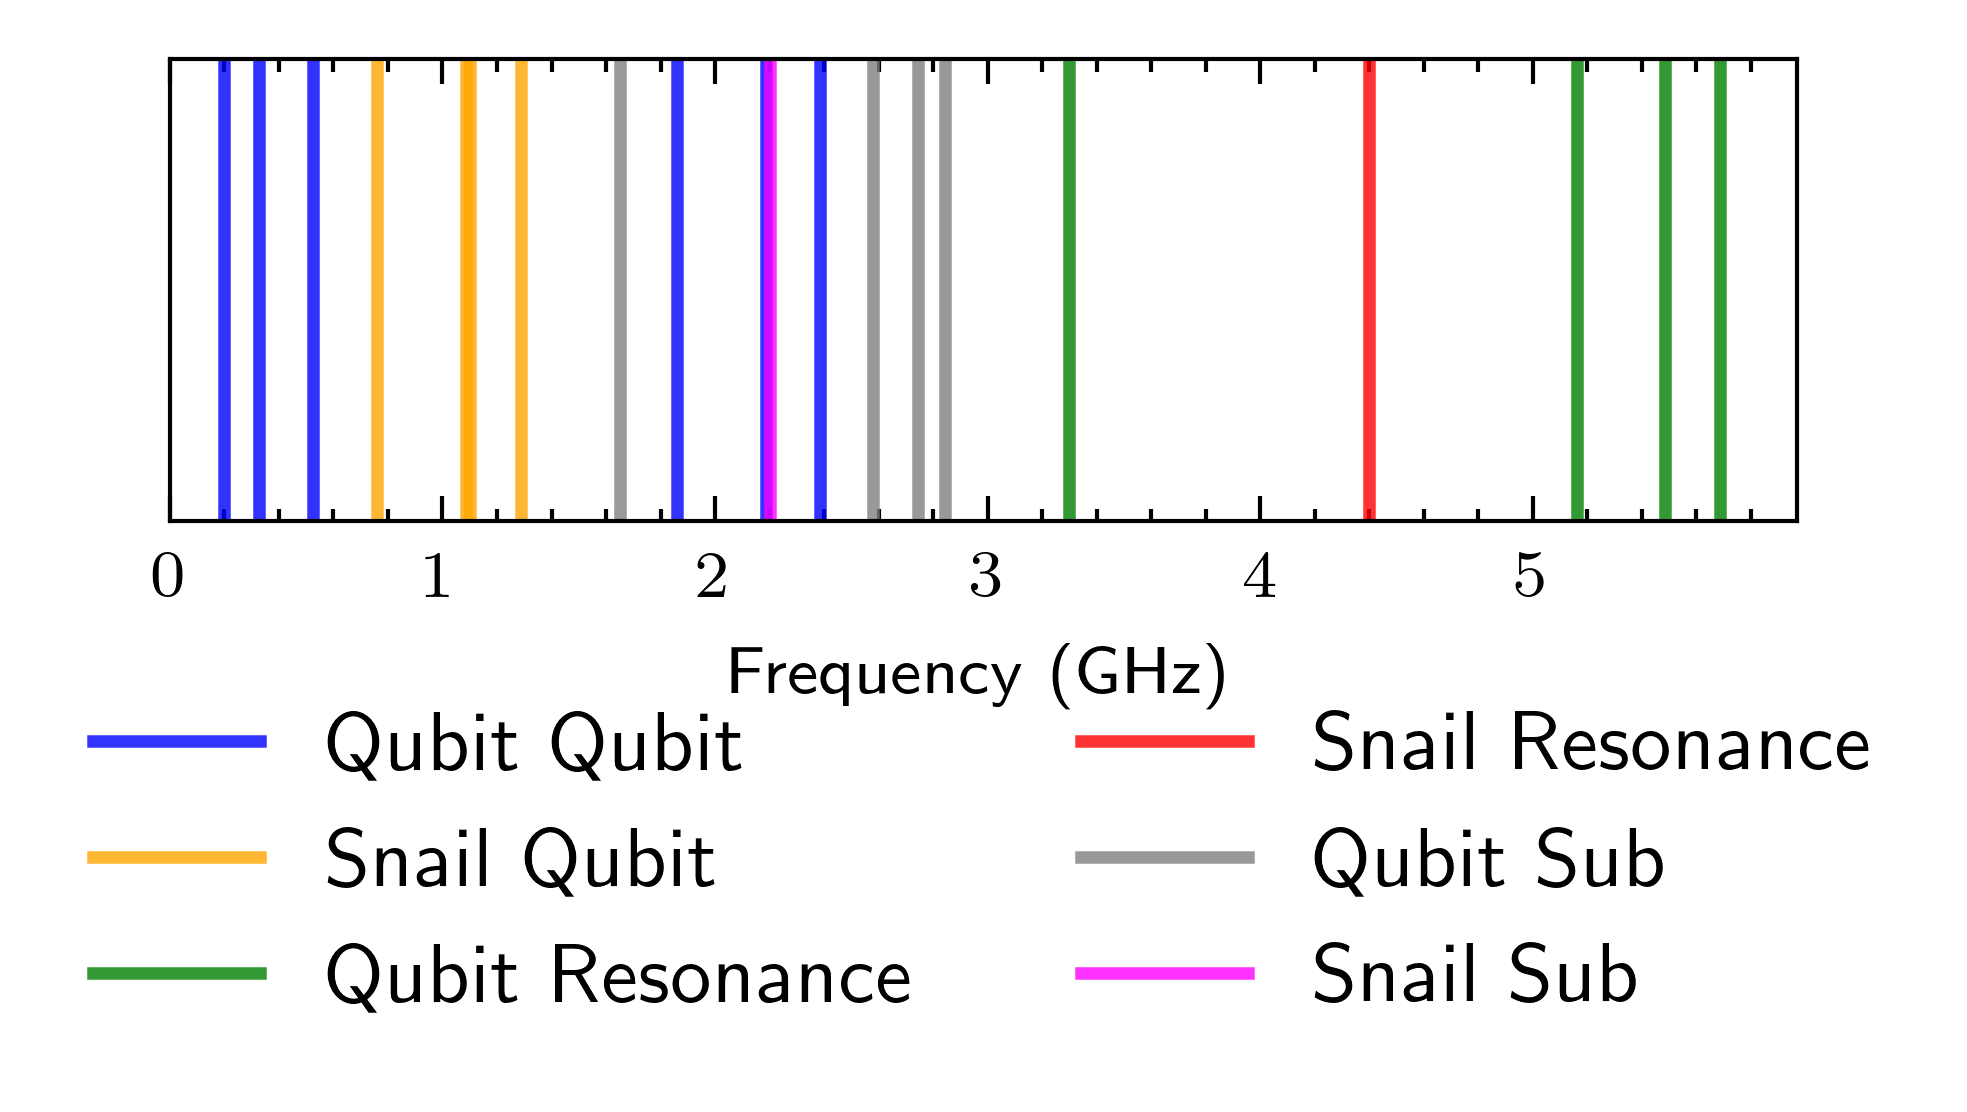


=== Module 2 ===
Qubit Frequencies: [3.300000000000315, 5.686506453094129, 5.486495816489926, 5.1604707113269015] GHz
SNAIL Frequency: 4.200042063007667 GHz
Gate Infidelities:
  Gate ('Q0', 'Q1'): 2.386506 GHz → fidelity (no lifetime loss): 9.918764e-01, fidelity (with lifetime loss): 9.882363e-01
  Gate ('Q0', 'Q2'): 2.186496 GHz → fidelity (no lifetime loss): 9.953178e-01, fidelity (with lifetime loss): 9.906597e-01
  Gate ('Q0', 'Q3'): 1.860471 GHz → fidelity (no lifetime loss): 9.872577e-01, fidelity (with lifetime loss): 9.834413e-01
  Gate ('Q1', 'Q2'): 0.200011 GHz → fidelity (no lifetime loss): 9.969996e-01, fidelity (with lifetime loss): 9.956648e-01
  Gate ('Q1', 'Q3'): 0.526036 GHz → fidelity (no lifetime loss): 9.889649e-01, fidelity (with lifetime loss): 9.874459e-01
  Gate ('Q2', 'Q3'): 0.326025 GHz → fidelity (no lifetime loss): 9.956299e-01, fidelity (with lifetime loss): 9.942273e-01

Average Gate fidelity (no lifetime loss): 0.9935783204065551
Average Gate fidelity (

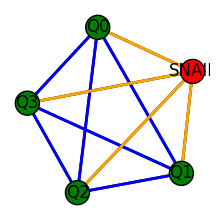

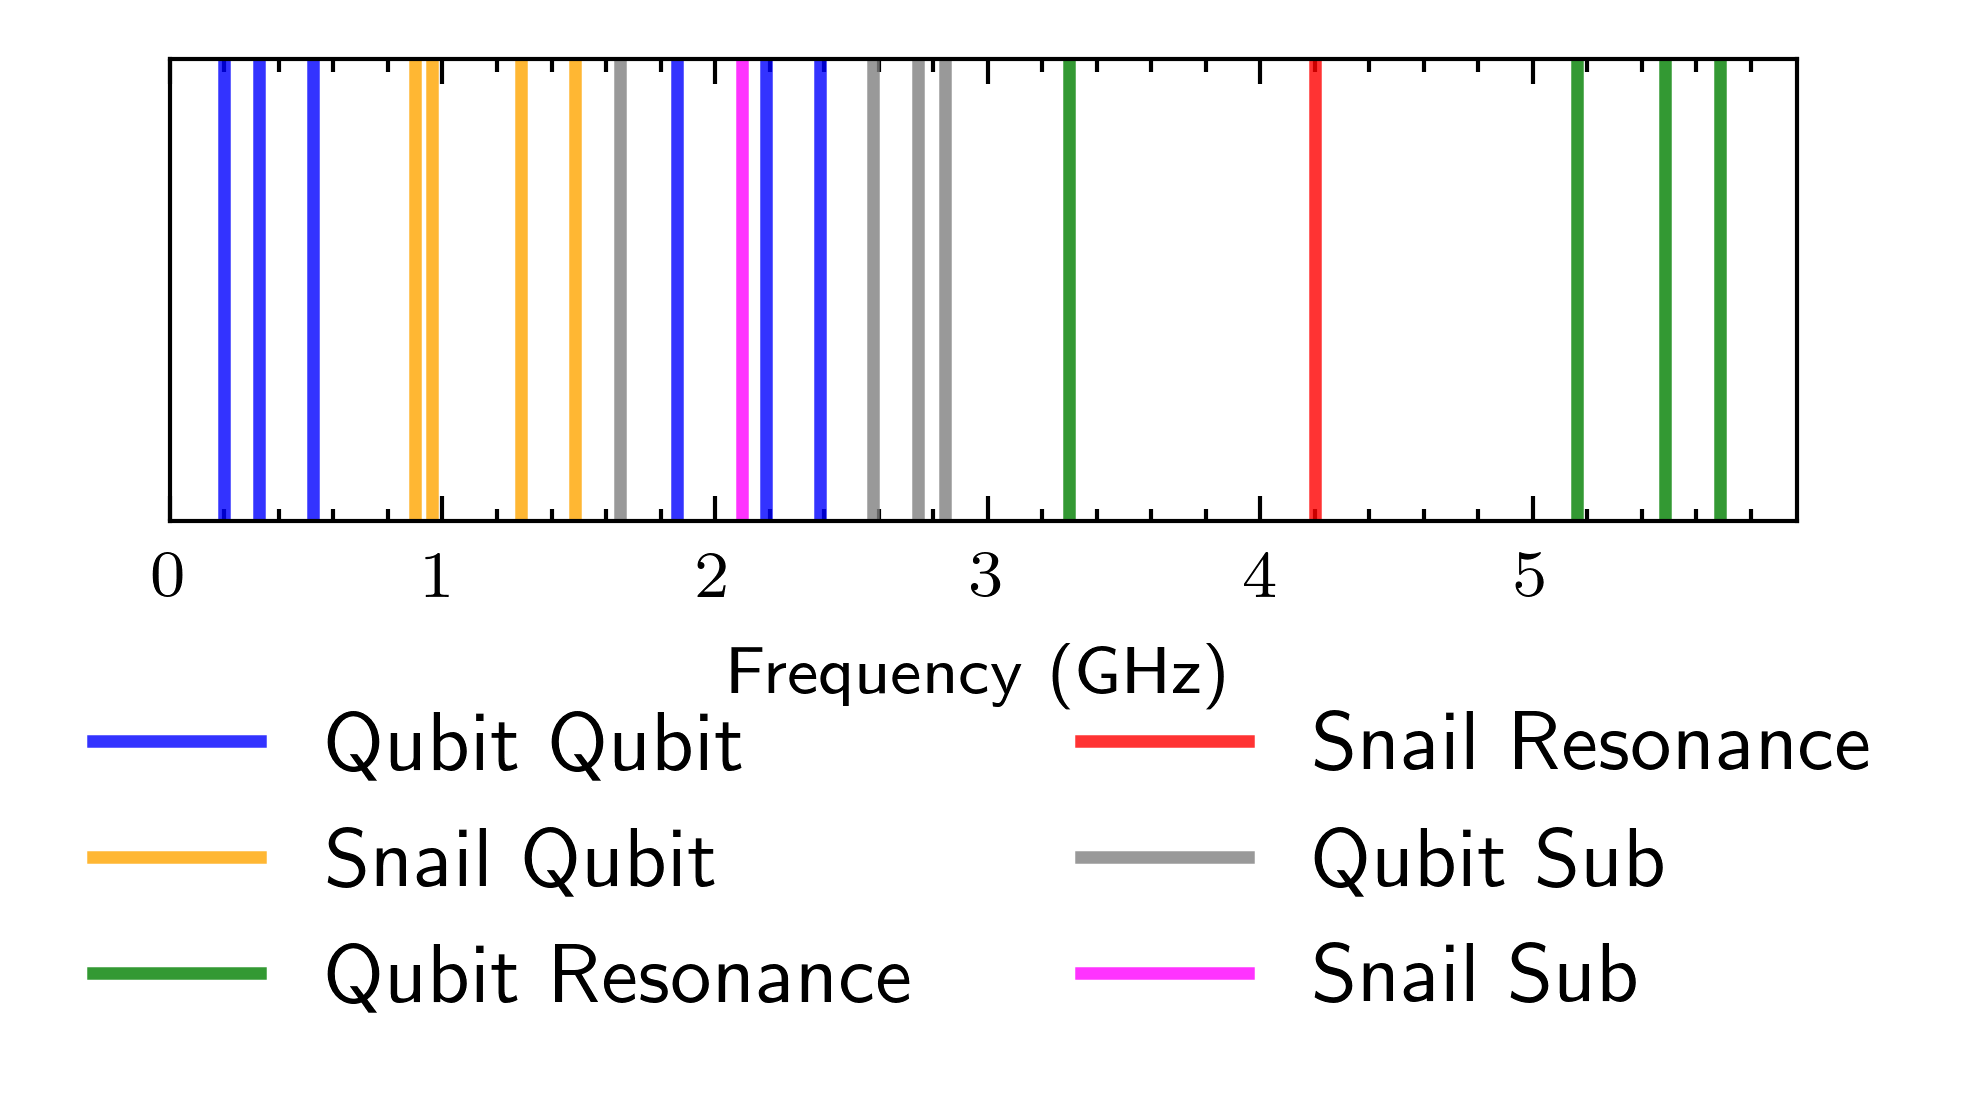

In [72]:
import numpy as np
from scipy.optimize import minimize

# Instantiate two module graphs using your existing class (can reuse same topology)
module = QuantumModuleGraph(num_qubits=4)  # Shared graph for both modules
optimizer1 = GateFidelityOptimizer(
    module,
    min_bare_space_ghz=0.2,
    lambdaq=0.08,
    eta=1.8,
    g3=60e6,
    qubit_bounds=(3.3, 5.7),
    snail_bounds=(4.2, 4.7),
    use_lifetime=True,
)
optimizer2 = GateFidelityOptimizer(
    module,
    min_bare_space_ghz=0.2,
    lambdaq=0.08,
    eta=1.8,
    g3=60e6,
    qubit_bounds=(3.3, 5.7),
    snail_bounds=(4.2, 4.7),
    use_lifetime=True,
)


def joint_objective(x):
    qubits = x[:4]
    snail1 = x[4]
    snail2 = x[5]

    x1 = list(qubits) + [snail1]
    x2 = list(qubits) + [snail2]

    cost1 = optimizer1.compute_total_infidelity(x1)
    cost2 = optimizer2.compute_total_infidelity(x2)

    # Penalty if SNAILs are too close
    snail_penalty = 0.0
    snail_spacing = np.abs(snail1 - snail2)
    if snail_spacing < 0.2:  # GHz
        snail_penalty = 1.0

    return cost1 + cost2 + snail_penalty


# Optimization bounds: 4 qubit freqs, 2 SNAIL freqs
bounds = [optimizer1.qubit_bounds] * 4 + [optimizer1.snail_bounds] * 2

best_cost = np.inf
best_result = None

for _ in tqdm(range(512)):
    x0 = np.append(
        np.random.uniform(*optimizer1.qubit_bounds, 4),
        # np.array([5.17970453, 5.37970967, 5.6997232, 3.30002947]),
        np.random.uniform(*optimizer1.snail_bounds, 2),
    )

    result = minimize(joint_objective, x0, bounds=bounds, method="Nelder-Mead")

    if result.fun < best_cost:
        best_cost = result.fun
        best_result = result

# Final assignment of best results
print("Best joint cost:", best_cost)
print("Frequencies:", best_result.x)

# Assign frequencies to each optimizer for reporting
optimizer1.best_frequencies = list(best_result.x[:4]) + [best_result.x[4]]
optimizer2.best_frequencies = list(best_result.x[:4]) + [best_result.x[5]]

# Report results
print("\n=== Module 1 ===")
optimizer1.get_final_infidelities()
optimizer1.report_results()

print("\n=== Module 2 ===")
optimizer2.get_final_infidelities()
optimizer2.report_results()

# Best joint cost: 0.1311122530805181
# Frequencies: [3.31495235 5.1705944  5.69067541 5.49066425 4.46028397 4.2602758 ]

In [ ]:
(4.400100368976565 / 2)

2.2000501844882825